In [83]:
import xgboost as xgb
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from NN_Learner import BatteryEmbedding, neural, ParameterLearner

In [84]:
# Loading the saved models
xgbrgr = xgb.XGBRegressor()
Emb = BatteryEmbedding(num_batteries=4, emb_dim=6)
ANN = neural(emb_dim=6)
Param = ParameterLearner(emb_dim=6)

Emb.load_state_dict(torch.load('emb_model.pth'))
ANN.load_state_dict(torch.load('ann_model.pth'))
Param.load_state_dict(torch.load('param_model.pth'))
xgbrgr.load_model('xgb_hybrid_model.json')

Emb.eval()
ANN.eval()
Param.eval()

C:\Users\deban\AppData\Local\Temp\ipykernel_18656\464829000.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Emb.load_state_dict(torch.load('emb_model.pth'))
C:\Users\deb

ParameterLearner(
  (net): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [91]:
full_df = pd.concat([pd.read_csv('train_data.csv'), pd.read_csv('test_data.csv')], ignore_index=True)
test_df = pd.read_csv('test_data.csv')

In [86]:
def generate_pinn_features(df, ann_model, emb_model, param_model):
    with torch.no_grad():
        t = torch.tensor(df['t_normalized'].values, dtype=torch.float32).unsqueeze(1)
        T_C_norm = torch.tensor(df['T_celsius_norm'].values, dtype=torch.float32).unsqueeze(1)
        I = torch.tensor(df['I_amperes_norm'].values, dtype=torch.float32).unsqueeze(1)
        bat_idx = torch.tensor(df['battery_idx'].values, dtype=torch.long)
        
        emb_features = emb_model(bat_idx)
        c_pred_features = ann_model(t, T_C_norm, I, emb_features)
        param_features = param_model(c_pred_features, emb_features)
        
        return emb_features.numpy(), param_features.numpy()

In [ ]:
def predict_rul(battery_id, start_cycle, eol_threshold,  all_data = full_df, model_xgb = xgbrgr, model_ann=ANN, model_emb=Emb, model_param=Param):
    """
    Predicts the RUL for a given battery starting from a specific cycle.
    """
    battery_cycles = all_data[all_data['battery_idx'] == battery_id]['cycle']
    min_cycle, max_cycle = battery_cycles.min(), battery_cycles.max()

    last_known_state = all_data[(all_data['battery_idx'] == battery_id) & (all_data['cycle'] == start_cycle)]
    
    start_df = pd.DataFrame([last_known_state.iloc[0]])
    start_emb, start_params = generate_pinn_features(start_df, model_ann, model_emb, model_param)
    
    start_emb_df = pd.DataFrame(start_emb, columns=[f'emb_{i}' for i in range(start_emb.shape[1])])
    start_params_df = pd.DataFrame(start_params, columns=['k', 'n', 'Ea'])

    x_loop = last_known_state.iloc[0].to_dict()
    future_cycle = start_cycle
    predicted_capacity = x_loop['C_target']
    forecast_curve = [(start_cycle, predicted_capacity)]

    print(f"Starting forecast from cycle: {start_cycle}, Initial Capacity: {predicted_capacity:.4f} Ah")

    while predicted_capacity > eol_threshold:
        future_cycle += 1
        
        next_step_df = pd.DataFrame([x_loop])
        next_step_df['t_normalized'] = (future_cycle - min_cycle) / (max_cycle - min_cycle)
        original_features_df = next_step_df[['t_normalized', 'T_celsius_norm', 'I_amperes_norm']]

        x_hybrid = pd.concat([original_features_df.reset_index(drop=True), start_emb_df, start_params_df], axis=1)
        
        new_capacity = model_xgb.predict(x_hybrid)[0]
        
        predicted_capacity = new_capacity
        forecast_curve.append((future_cycle, new_capacity))

        if future_cycle % 20 == 0:
            print(f"  ... Forecasting Cycle: {future_cycle}, Predicted Capacity: {predicted_capacity:.4f} Ah")

    print(f"Forecast stopped at Cycle: {future_cycle}, Final Capacity: {predicted_capacity:.4f} Ah")
    
    predicted_rul = future_cycle - start_cycle
    return predicted_rul, forecast_curve

In [ ]:
val_battery_id = 3 
EOL_THRESHOLD = 1.45  # End-of-Life when capacity drops below 1.45 Ah
battery_test_data = test_df[test_df['battery_idx'] == val_battery_id]
val_start_cycle = battery_test_data['cycle'].iloc[0]


# Run the RUL prediction
predicted_rul, forecast_curve = predict_rul(
    battery_id=val_battery_id,
    start_cycle=val_start_cycle,
    all_data=full_df,
    eol_threshold=EOL_THRESHOLD,
    model_xgb=xgbrgr,
    model_ann=ANN,
    model_emb=Emb,
    model_param=Param
)

# Find the ground truth RUL from the dataset for comparison
true_rul = test_df.loc[(test_df['battery_idx'] == val_battery_id) & (test_df['cycle'] == val_start_cycle), 'RUL'].values[0]

print(f"--- RUL Prediction for Battery B0007 (ID: {val_battery_id}) ---")
print(f"Starting forecast from cycle: {val_start_cycle}")
print(f"Predicted RUL: {predicted_rul} cycles")
print(f"True RUL from data: {true_rul} cycles")
print(f"Error: {abs(predicted_rul - true_rul)} cycles")

Starting forecast from cycle: 75, Initial Capacity: 1.6993 Ah
  ... Forecasting Cycle: 80, Predicted Capacity: 1.6980 Ah
  ... Forecasting Cycle: 100, Predicted Capacity: 1.6859 Ah
  ... Forecasting Cycle: 120, Predicted Capacity: 1.6868 Ah
  ... Forecasting Cycle: 140, Predicted Capacity: 1.6579 Ah
  ... Forecasting Cycle: 160, Predicted Capacity: 1.5996 Ah
  ... Forecasting Cycle: 180, Predicted Capacity: 1.5536 Ah
  ... Forecasting Cycle: 200, Predicted Capacity: 1.5104 Ah
  ... Forecasting Cycle: 220, Predicted Capacity: 1.4964 Ah
  ... Forecasting Cycle: 240, Predicted Capacity: 1.4811 Ah
  ... Forecasting Cycle: 260, Predicted Capacity: 1.4828 Ah
  ... Forecasting Cycle: 280, Predicted Capacity: 1.4634 Ah
  ... Forecasting Cycle: 300, Predicted Capacity: 1.4632 Ah
Forecast stopped at Cycle: 306, Final Capacity: 1.4488 Ah
--- RUL Prediction for Battery B0007 (ID: 3) ---
Starting forecast from cycle: 75
Predicted RUL: 231 cycles
True RUL from data: 244 cycles
Error: 13 cycles


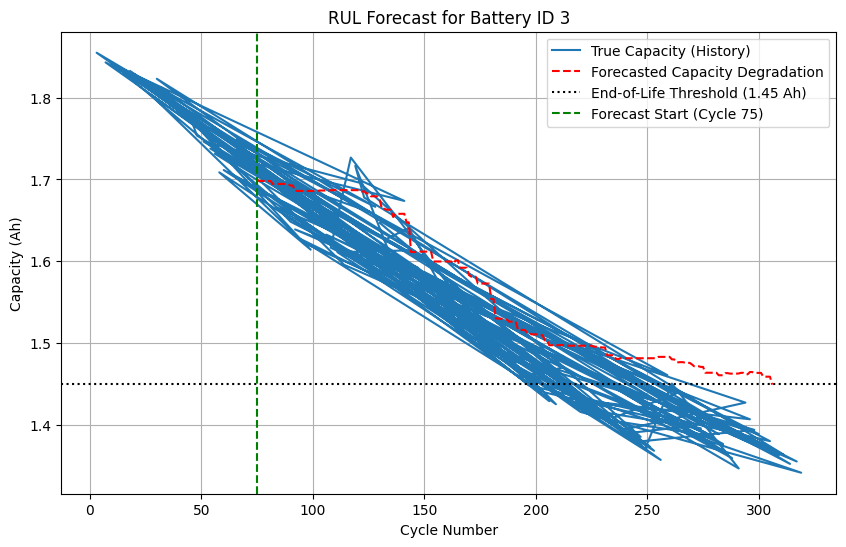

In [96]:
history_df = full_df[full_df['battery_idx'] == val_battery_id]
forecast_df = pd.DataFrame(forecast_curve, columns=['cycle', 'capacity'])

plt.figure(figsize=(10, 6))
plt.plot(history_df['cycle'], history_df['C_target'], label='True Capacity (History)')
plt.plot(forecast_df['cycle'], forecast_df['capacity'], 'r--', label='Forecasted Capacity Degradation')
plt.axhline(y=EOL_THRESHOLD, color='k', linestyle=':', label=f'End-of-Life Threshold ({EOL_THRESHOLD} Ah)')
plt.axvline(x=val_start_cycle, color='g', linestyle='--', label=f'Forecast Start (Cycle {val_start_cycle})')
plt.title(f'RUL Forecast for Battery ID {val_battery_id}')
plt.xlabel('Cycle Number')
plt.ylabel('Capacity (Ah)')
plt.legend()
plt.grid(True)
plt.show()